In [2]:
# Imports
import pandas as pd
import torch
import re
from tqdm import tqdm
from collections import Counter

In [3]:
# Detect device
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("cpu") # CPU was faster for me
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()
device # The device on which we want to run everything

device(type='cpu')

### Direct link to the dataset used: https://grouplens.org/datasets/movielens/10m/

In [5]:
# Read the ratings csv file
ratings = pd.read_csv("Data/ml-10M100K/ratings.dat", delimiter='::', names=["userId", "movieId", "rating", "timestamp"])
ratings.head() # The DataFrame contain user ratings for movies

print(Counter(ratings["userId"]))

/var/folders/fw/gv9151hn4f5d0g759kny_1fm0000gn/T/ipykernel_57883/2314181059.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("Data/ml-10M100K/ratings.dat", delimiter='::', names=["userId", "movieId", "rating", "timestamp"])


Counter({59269: 7359, 67385: 7047, 14463: 5169, 68259: 4483, 27468: 4449, 3817: 4165, 19635: 4165, 63134: 3755, 58357: 3697, 27584: 3479, 6757: 3414, 56707: 3225, 19379: 3202, 7795: 3187, 8811: 3164, 30723: 3027, 30687: 2909, 31327: 2886, 30500: 2827, 47046: 2812, 42791: 2806, 47345: 2801, 62332: 2766, 14134: 2753, 57126: 2697, 30158: 2644, 51033: 2634, 59659: 2608, 59598: 2601, 38928: 2555, 10858: 2533, 58087: 2533, 1860: 2529, 53649: 2529, 53315: 2522, 29643: 2478, 30167: 2453, 43992: 2451, 17438: 2422, 27825: 2400, 41253: 2391, 36771: 2358, 16681: 2353, 31854: 2345, 39294: 2341, 66788: 2339, 67542: 2339, 5134: 2337, 25239: 2320, 70244: 2306, 61632: 2265, 29892: 2263, 33399: 2259, 36812: 2243, 24695: 2239, 10759: 2227, 47213: 2223, 35442: 2218, 40524: 2216, 11760: 2213, 23858: 2206, 38234: 2200, 71190: 2189, 28232: 2188, 29707: 2179, 55005: 2179, 16227: 2176, 27003: 2174, 40751: 2171, 22842: 2170, 40676: 2170, 42447: 2168, 5678: 2152, 16003: 2145, 38410: 2139, 57481: 2133, 41154: 212

In [6]:
# Read the movies csv file
movies = pd.read_csv("Data/ml-10M100K/movies.dat", delimiter="::", names=["movieId","title","genres"])
movies.head() # The DataFrame containing further movie info

/var/folders/fw/gv9151hn4f5d0g759kny_1fm0000gn/T/ipykernel_57883/3774078924.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("Data/ml-10M100K/movies.dat", delimiter="::", names=["movieId","title","genres"])


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Combine the two DataFrames along the movieId column and delete the timestamp column
combined = pd.merge(ratings, movies, on="movieId")
del combined["timestamp"]
combined.head() # The DataFrame containing user ratings and movie info

,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
1,1,185,5.0,"Net, The (1995)",Action|Crime|Thriller
2,1,231,5.0,Dumb & Dumber (1994),Comedy
3,1,292,5.0,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
4,1,316,5.0,Stargate (1994),Action|Adventure|Sci-Fi


In [8]:
# Construct a new DataFrame which contains all the features of our model
movie_ratings = pd.DataFrame()
movie_ratings["userId"] = combined["userId"]
movie_ratings["movieId"] = combined["movieId"]

# Split the title across spaces (removing special characters).
# Create a column for the words in the title and a column for the year.
split_titles = [re.sub('[^a-zA-Z0-9 ]', '', title).split(' ') for title in combined["title"]]
movie_ratings["title_words"] = [title[:-1] for title in split_titles]
movie_ratings["year"] = [title[-1] for title in split_titles]

# Split the genres across the bar. Keep in (no genres listed) since it gives some information.
movie_ratings["genres"] = [genres.split('|') for genres in combined["genres"]]

# Place the ratings column in the last position.
movie_ratings["rating"] = combined["rating"]

movie_ratings.head()

,userId,movieId,title_words,year,genres,rating
0,1,122,[Boomerang],1992,"[Comedy, Romance]",5.0
1,1,185,"[Net, The]",1995,"[Action, Crime, Thriller]",5.0
2,1,231,"[Dumb, , Dumber]",1994,[Comedy],5.0
3,1,292,[Outbreak],1995,"[Action, Drama, Sci-Fi, Thriller]",5.0
4,1,316,[Stargate],1994,"[Action, Adventure, Sci-Fi]",5.0


In [9]:
# Map each of the non-rating columns to indices.

# Get sets containing all distinct values in each column.
# (For columns containing lists: the distinct elements in the lists)
unique_users = set(movie_ratings['userId'])
unique_movies = set(movie_ratings['movieId'])
title_words = set([w for words in movie_ratings['title_words'] for w in words])
title_years = set(movie_ratings['year'])
genres = set([g for gs in movie_ratings['genres'] for g in gs])

# Consider only the first 3 words in the title and the first 2 genres
max_title_words = 3
max_genres = 2

# Create mappings from values to indices.
# For the columns containing lists the index is +1 since we
# need the index 0 to perform padding.
# (DataLoader requires that lists all contain the same # of els)
user_to_index = {user: i for i, user in enumerate(unique_users)}
movie_to_index = {movie: i for i, movie in enumerate(unique_movies)}
title_word_to_index = {word: i+1 for i, word in enumerate(title_words)}
year_to_index = {year: i for i, year in enumerate(title_years)}
genre_to_index = {genre: i+1 for i, genre in enumerate(genres)}

# Apply the mappings to the columns
movie_ratings["userId"] = [user_to_index[user] for user in movie_ratings["userId"]]
movie_ratings["movieId"] = [movie_to_index[movie] for movie in movie_ratings["movieId"]]
movie_ratings["title_words"] = [([title_word_to_index[word] for word in words][:max_title_words] + [0] * (max_title_words - len(words))) for words in movie_ratings["title_words"]]
movie_ratings["year"] = [year_to_index[year] for year in movie_ratings["year"]]
movie_ratings["genres"] = [([genre_to_index[genre] for genre in genres][:max_genres] + [0] * (max_genres - len(genres))) for genres in movie_ratings["genres"]]
movie_ratings.head()

,userId,movieId,title_words,year,genres,rating
0,0,121,"[10514, 0, 0]",19,"[5, 1]",5.0
1,0,184,"[4453, 3477, 0]",32,"[13, 6]",5.0
2,0,230,"[2953, 1, 1997]",86,"[5, 0]",5.0
3,0,291,"[45, 0, 0]",32,"[13, 11]",5.0
4,0,315,"[4565, 0, 0]",86,"[13, 19]",5.0


In [10]:
# Sort movie ratings by userId
# (Ensures that the train / test / val splits all approximately contain different users)
movie_ratings = movie_ratings.sort_values(by="userId")

In [11]:
# Define the two-tower models as embedding layers followed by feed-forward networks.
layer_dim = 128 # Dimension to which the embedding is mapped

class Tower1_U(torch.nn.Module):
    def __init__(self, num_users, z_dims):
        """
        num_users: The number of unique users
        z_dims: The dimensions of the embeddings (and augmented vector)
        out_dim: The output dimension
        """
        super().__init__()
        self.embed = torch.nn.Embedding(num_users, z_dims[0])
        self.lin1 = torch.nn.Linear(torch.sum(z_dims), layer_dim)
        self.relu1 = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(layer_dim, 1)
        self.relu2 = torch.nn.ReLU()

    def forward(self, user_ids):
        embeds = self.embed(user_ids)
        z_u = embeds
        x = self.lin1(z_u)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        return torch.norm(x, dim=1)

class Tower2_M(torch.nn.Module):
    def __init__(self, num_movies, num_title_words, num_years, num_genres, z_dims):
        """
        num_users: The number of unique users
        num_genres: The number of unique genres
        z_dims: The dimensions of the embeddings (and augmented vector)
        out_dim: The output dimension
        """
        super().__init__()
        self.embed_id = torch.nn.Embedding(num_movies, z_dims[0])
        self.embed_title = torch.nn.Embedding(num_title_words, z_dims[1])
        self.embed_year = torch.nn.Embedding(num_years, z_dims[2])
        self.embed_genre = torch.nn.Embedding(num_genres, z_dims[3])
        self.lin1 = torch.nn.Linear(torch.sum(z_dims), layer_dim)
        self.relu1 = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(layer_dim, 1)
        self.relu2 = torch.nn.ReLU()

    def forward(self, movie_ids, title_words, year, genres):
        embeds_id = self.embed_id(movie_ids)

        embeds_title = self.embed_title(title_words).sum(dim=1) # The list we have of words creates a new dimension in our input tensor, which we sum over
        
        embeds_year = self.embed_year(year)

        embeds_genre = self.embed_genre(genres).sum(dim=1) # Idem

        z_u = torch.hstack((embeds_id, embeds_title, embeds_year, embeds_genre))
        x = self.lin1(z_u)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        return torch.norm(x, dim=1)

In [12]:
# Get the number of unique elements in each column
# In the list-containing columns we add 1 to account
# for the padding index 0 we introduced.
num_users = len(unique_users)
num_movies = len(unique_movies)
num_title_words = len(title_words)+1
num_years = len(title_years)
num_genres = len(genres)+1

In [13]:
# Create a loader for our data. We move everything to tensors
# in the init to speed up training.

class TwoTowerLoader:
    def __init__(self, movie_ratings_df):
        self.movie_ratings_df = movie_ratings_df
        self.user_ids = torch.tensor(movie_ratings_df["userId"].values, dtype=torch.int, device=device)
        self.movie_ids = torch.tensor(movie_ratings_df["movieId"].values, dtype=torch.int, device=device)
        self.title_words = torch.tensor(movie_ratings_df["title_words"].values.tolist(), dtype=torch.int, device=device)
        self.years = torch.tensor(movie_ratings_df["year"].values, dtype=torch.int, device=device)
        self.genres = torch.tensor(movie_ratings_df["genres"].values.tolist(), dtype=torch.int, device=device)
        self.ratings = torch.tensor(movie_ratings_df["rating"].values, dtype=torch.float, device=device)

    def __len__(self):
        return len(self.movie_ratings_df)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        movie_id = self.movie_ids[idx]
        title_words = self.title_words[idx]
        year = self.years[idx]
        genres = self.genres[idx]
        rating = self.ratings[idx]

        return user_id, movie_id, title_words, year, genres, rating

In [14]:
import random

unique_user_list = list(unique_users)
random.seed(1)
random.shuffle(unique_user_list)

data_factor = 0.1

train_split = int(0.9*len(unique_user_list))
test_split = int(0.95*len(unique_user_list))

train_users = unique_user_list[:train_split]
test_users = unique_user_list[int(0.9*len(unique_user_list)):test_split]

# Get the data_factor most active users as training users only
active_users_counter = Counter(movie_ratings.loc[movie_ratings['userId'].isin(train_users)]['userId'])
active_users_only_pairs = active_users_counter.most_common(int(data_factor*len(train_users)))

active_users_only = [user for user, _ in active_users_only_pairs]

print(f"Number of users in the training set: {len(active_users_only)} ({data_factor*100}%)")
train_users = active_users_only

Number of users in the training set: 6289 (10.0%)


In [15]:
z_dims_u = torch.tensor([64]) # The dimensions for embeddings of the user model input
z_dims_m = torch.tensor([64, 128, 128, 64]) # The dimensions for embeddings of the movie model input
batch_size = 128

# As we shuffled the selected users when making the splits, we can use the property that they are sorted in the dataframe to treat
# the minimun amount of reviews (20) as batch size and only train on one user at a time 

twoTowerLoaderTrain = torch.utils.data.DataLoader(
    TwoTowerLoader(movie_ratings[movie_ratings['userId'].isin(train_users)]),
    batch_size=batch_size,
    shuffle=True
)

twoTowerLoaderTest = torch.utils.data.DataLoader(
    TwoTowerLoader(movie_ratings[movie_ratings['userId'].isin(test_users)]),
    batch_size=batch_size,
    shuffle=True
)

In [16]:
modelU = Tower1_U(num_users, z_dims_u).to(device)
modelM = Tower2_M(num_movies, num_title_words, num_years, num_genres, z_dims_m).to(device)

epochs = 1
lr = 0.001

loss_fn = torch.nn.MSELoss()

optimizerU = torch.optim.Adam(modelU.parameters(), lr=lr)
optimizerM = torch.optim.Adam(modelM.parameters(), lr=lr)

for epoch in range(epochs):
    total_loss = 0
    batches_done_train = 0
    batches_done_test = 0

    # Train on the train set
    for user_id, movie_id, title_words, year, genres, rating in tqdm(twoTowerLoaderTrain):
        # Skip the last batch (because of shape issues)
        if len(rating) != batch_size:
            continue

        batches_done_train += 1

        optimizerU.zero_grad()
        optimizerM.zero_grad()

        outputU = modelU(user_id)
        outputM = modelM(movie_id, title_words, year, genres)

        interaction = outputU * outputM

        lossInteraction = loss_fn(interaction.squeeze(), rating)

        lossInteraction.backward()

        optimizerU.step()
        optimizerM.step()

        total_loss += lossInteraction.item()

    # Evaluate on the test set
    with torch.no_grad():
        total_loss_test = 0

        for user_id, movie_id, title_words, year, genres, rating in tqdm(twoTowerLoaderTest):
            if len(rating) != batch_size: 
                continue
            
            batches_done_test += 1
            outputU = modelU(user_id)
            outputM = modelM(movie_id, title_words, year, genres)

            interaction = outputU * outputM
            lossInteraction = loss_fn(interaction.squeeze(), rating)

            total_loss_test += lossInteraction.item()

    print(f"Epoch {epoch + 1}: train batches: {batches_done_train}, test batches: {batches_done_test}")
    print(f"Epoch {epoch + 1}: train_loss: {round(total_loss / batches_done_train,3)}, test_loss: {round(total_loss_test / batches_done_test,3)}")


100%|██████████| 3703/3703 [00:06<00:00, 601.19it/s]

Epoch 1: train batches: 31055, test batches: 3702
Epoch 1: train_loss: 0.763, test_loss: 0.98


In [17]:
# Define some untrained models.
modelU_untrained = Tower1_U(num_users, z_dims_u).to(device)
modelM_untrained = Tower2_M(num_movies, num_title_words, num_years, num_genres, z_dims_m).to(device)

In [18]:
import statistics
import numpy as np

all_ratings = movie_ratings["rating"]

mean = statistics.mean(all_ratings)
stdev = statistics.stdev(all_ratings)

print(f"Ratings mean: {mean}, stdev: {stdev}")
print(f"Sample: {np.random.normal(mean, stdev, 1)}")


Ratings mean: 3.512421932921562, stdev: 1.0604184716263543
Sample: [3.61955599]


In [19]:
from functools import cache

trainDF = movie_ratings[movie_ratings['userId'].isin(train_users)]

@cache
def get_movie_stats(movie_id):
    specific_ratings = trainDF.loc[trainDF["movieId"] == movie_id]["rating"]
    count = len(specific_ratings)

    if count <= 1:
        if count == 1:
            mean = float(specific_ratings.iloc[0])
        else:
            count = 1
            mean = 0
        stdev = 0
    else:
        mean = statistics.mean(specific_ratings)
        stdev = statistics.stdev(specific_ratings)
    return mean, stdev, count

In [20]:
# Make predictions for the test set, sort them and take the top 100. Then calculate the precision and recall
import math

thresh = 4
topX = 100
dumb_dumb_value = 4.70

# Evaluate on the test set
with torch.no_grad():
    total_loss_test = 0
    predictions = []
    predictions_untrained = []
    dumb = []
    popular = []
    dumb_dumb_dumb = []

    for user_id, movie_id, title_words, year, genres, rating in tqdm(twoTowerLoaderTest):
        # print(user_id)
        if rating.size(0) != batch_size: #or len(user_id.unique()) > 1:
            continue

        outputU = modelU(user_id)
        outputM = modelM(movie_id, title_words, year, genres)

        # Our prediction is the product of the output vectors of the two towers
        interaction = outputU * outputM

        for i in range(batch_size):
            predictions.append((interaction[i].item(), rating[i].item()))

            # We take the normal distribution of each movie to simulate an alternative to the model
            mId = movie_id[i].item()

            mean, stdev, rating_count = get_movie_stats(mId)

            # print((16-math.log10(rating_count))/3.15)

            if mean > 1.1*thresh:#(16-math.log10(rating_count))/3.15:
                popular.append((5.0, rating[i].item()))
            else:
                popular.append((0.0, rating[i].item()))

            dumb.append((np.random.normal(mean, stdev, 1), rating[i].item()))

            dumb_dumb_dumb.append((dumb_dumb_value, rating[i].item()))


    trained_TP = [1 for p in predictions if p[0] >= thresh and p[1] >= thresh]
    trained_FP = [1 for p in predictions if p[0] >= thresh and p[1] <= thresh]
    trained_FN = [1 for p in predictions if p[0] <= thresh and p[1] >= thresh]

    dumb_TP = [1 for p in dumb if p[0] >= thresh and p[1] >= thresh]
    dumb_FP = [1 for p in dumb if p[0] >= thresh and p[1] <= thresh]
    dumb_FN = [1 for p in dumb if p[0] <= thresh and p[1] >= thresh]

    popular_TP = [1 for p in popular if p[0] >= thresh and p[1] >= thresh]
    popular_FP = [1 for p in popular if p[0] >= thresh and p[1] <= thresh]
    popular_FN = [1 for p in popular if p[0] <= thresh and p[1] >= thresh]

    brainless_TP = [1 for p in dumb_dumb_dumb if p[0] >= thresh and p[1] >= thresh]
    brainless_FP = [1 for p in dumb_dumb_dumb if p[0] >= thresh and p[1] <= thresh]
    brainless_FN = [1 for p in dumb_dumb_dumb if p[0] <= thresh and p[1] >= thresh]

    try:
        precision = sum(trained_TP) / (sum(trained_TP) + sum(trained_FP))
    except ZeroDivisionError as e:
        precision = 0.0

    try:
        recall = sum(trained_TP) / (sum(trained_TP) + sum(trained_FN))
    except ZeroDivisionError as e:
        recall = 0.0

    try:
        precision_dumb = sum(dumb_TP) / (sum(dumb_TP) + sum(dumb_FP))
    except ZeroDivisionError as e:
        precision_dumb = 0.0

    try:
        recall_dumb = sum(dumb_TP) / (sum(dumb_TP) + sum(dumb_FN))
    except ZeroDivisionError as e:
        recall_dumb = 0.0

    try:
        precision_popular = sum(popular_TP) / (sum(popular_TP) + sum(popular_FP))
    except ZeroDivisionError as e:
        precision_popular = 0.0

    try:
        recall_popular = sum(popular_TP) / (sum(popular_TP) + sum(popular_FN))
    except ZeroDivisionError as e:
        recall_popular = 0.0

    try:
        precision_brainless = sum(brainless_TP) / (sum(brainless_TP) + sum(brainless_FP))
    except ZeroDivisionError as e:
        precision_brainless = 0.0

    try:
        recall_brainless = sum(brainless_TP) / (sum(brainless_TP) + sum(brainless_FN))
    except ZeroDivisionError as e:
        recall_brainless = 0.0

    print(f"Precision: {precision}, Recall: {recall}\n")

    print(f"Popular: all predicstions are taken from the normal distribution of that movie rating.")
    print(f"Popular (popular): {precision_popular}, Recall (popular): {recall_popular}\n")

    print(f"Dumb: all predicstions are taken from the normal distribution of that movie rating.")
    print(f"Precision (dumb): {precision_dumb}, Recall (dumb): {recall_dumb}\n")

    print(f"Brainless: all predicstions are the value {dumb_dumb_value}.")
    print(f"Precision (Brainless): {precision_brainless}, Recall (Brainless): {recall_brainless}")

100%|██████████| 3703/3703 [00:33<00:00, 109.59it/s]


Precision: 0.5559474661643086, Recall: 0.17438843976178803

Popular: all predicstions are taken from the normal distribution of that movie rating.
Popular (popular): 0.700652528548124, Recall (popular): 0.00360000167636865

Dumb: all predicstions are taken from the normal distribution of that movie rating.
Precision (dumb): 0.4584392130539707, Recall (dumb): 0.36064522618119643

Brainless: all predicstions are the value 4.7.
Precision (Brainless): 0.39124189800961173, Recall (Brainless): 1.0


In [21]:
print(Counter([round(p[0], 0) for p in predictions]))
print(Counter([round(p[1], 0) for p in predictions]))

Counter({3.0: 240338, 4.0: 195782, 2.0: 32088, 5.0: 5414, 1.0: 234})
Counter({4.0: 206391, 3.0: 110581, 5.0: 74515, 2.0: 61095, 1.0: 16920, 0.0: 4354})


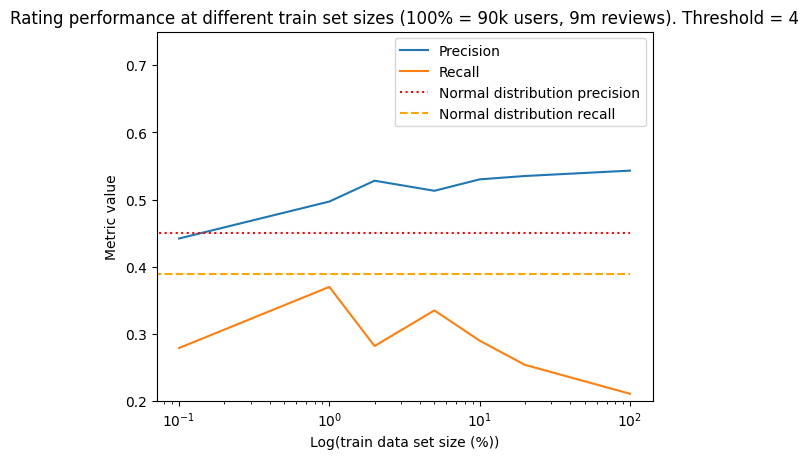

In [22]:
import matplotlib.pyplot as plt

precs = {0.1:0.442, 1:0.497, 2:0.528, 5:0.513, 10:0.53, 20:0.535, 100:0.543}#}
recs = {0.1:0.279, 1:0.37, 2:0.282, 5:0.335, 10:0.29, 20:0.254, 100:0.211}#}

plt.xscale("log")
plt.plot(list(precs.keys()), list(precs.values()), label="Precision")
plt.plot(list(recs.keys()), list(recs.values()), label="Recall")
plt.hlines(y=0.45, color="r", xmin=0, xmax= 100, linestyles=":", label="Normal distribution precision")
plt.hlines(y=0.389, color="orange", xmin=0, xmax= 100, linestyles="--", label="Normal distribution recall")
plt.ylim(0.2, 0.75)
plt.legend()
plt.xlabel("Log(train data set size (%))")
plt.ylabel("Metric value")
plt.title("Rating performance at different train set sizes (100% = 90k users, 9m reviews). Threshold = 4")
plt.show()

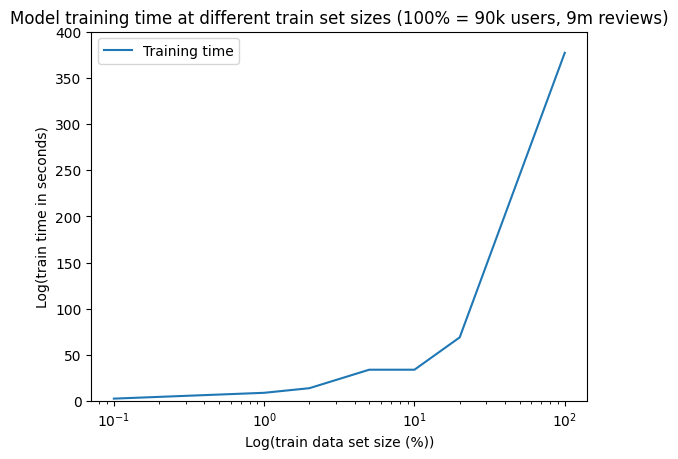

In [23]:
tt = {0.1:2.7, 1:9, 2:14, 5:34, 10:34, 20:69, 100:377}

plt.xscale("log")
# plt.yscale("log")
plt.plot(list(tt.keys()), list(tt.values()), label="Training time")
plt.ylim(0, 400)
plt.legend()
plt.xlabel("Log(train data set size (%))")
plt.ylabel("Log(train time in seconds)")
plt.title("Model training time at different train set sizes (100% = 90k users, 9m reviews)")
plt.show()

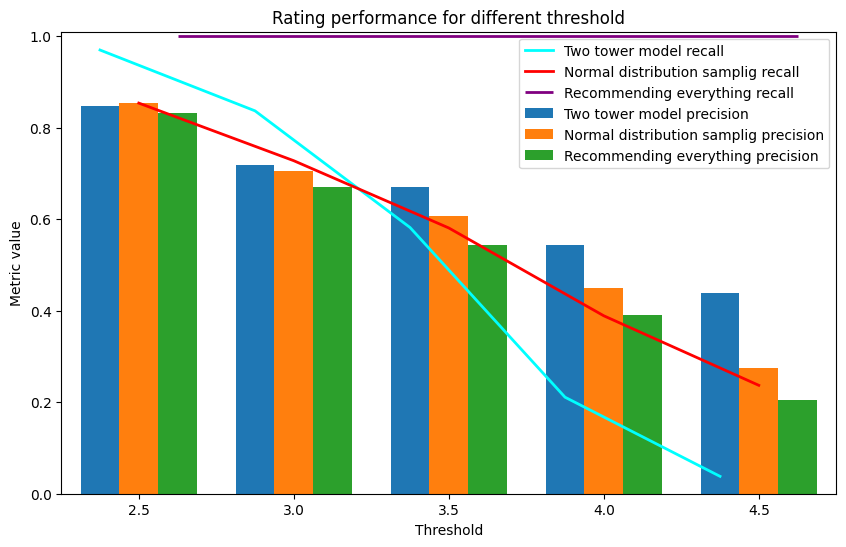

In [24]:
precs = {2.5:0.848, 3.0:0.718, 3.5:0.67, 4.0:0.543, 4.5:0.438}
recs = {2.5:0.97, 3.0:0.837, 3.5:0.582, 4.0:0.211, 4.5:0.038}

precs_distrib = {2.5:0.854, 3.0:0.705, 3.5:0.607, 4.0:0.45, 4.5:0.274}
recs_distrib = {2.5:0.854, 3.0:0.728, 3.5:0.581, 4.0:0.389, 4.5:0.237}

precs_rec_all = {2.5:0.833, 3.0:0.67, 3.5:0.544, 4.0:0.391, 4.5:0.204}

wdt = 0.125
offset = wdt

# plt.xscale("log")
plt.figure(figsize=(10,6))
plt.bar(list(map(lambda x: x-offset, list(precs.keys()))), list(precs.values()), label="Two tower model precision", width=wdt)
plt.bar(list(precs_distrib.keys()), list(precs_distrib.values()), label="Normal distribution samplig precision", width=wdt)
plt.bar(list(map(lambda x: x + offset, list(precs_rec_all.keys()))), list(precs_rec_all.values()), label="Recommending everything precision", width=wdt)

plt.plot(list(map(lambda x: x-offset, list(precs.keys()))), list(recs.values()), label="Two tower model recall", c="cyan", linewidth = 2)
plt.plot(list(recs_distrib.keys()), list(recs_distrib.values()), label="Normal distribution samplig recall", c="red", linewidth = 2)

plt.hlines(y=1, color="purple", xmin=2.625, xmax= 4.625, linestyles="-", label="Recommending everything recall",linewidth=2)

plt.ylim(0, 1.01)
plt.xlim(2.25, 4.75)
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Rating performance for different threshold")
plt.show()